In [4]:
# # Loan Repayment Capability Prediction
#
# ## 1. Problem Definition
# Predict customers' loan repayment capability (0-1 score) based on financial behavior, demographics, and living conditions.

# %%
# Import required libraries
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import pickle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.4/322.4 MB 3.4 MB/s eta 0:00:00


In [5]:
# ## 2. Data Collection & Loading
# Load the dataset (assuming it's named 'data.csv' in the same directory)

# %%
# Load data
# Correct the URL to access the raw CSV data from GitHub
data = pd.read_csv('https://raw.githubusercontent.com/UnsettledAverage73/Matrix-AI-Protocol/main/Rigorous2/Synthetic-Data/data.csv')

# Display first 5 rows
data.head()


,id,occupation,upi_txns_month,mobile_recharge_freq,night_light,education,is_urban,bill_payment_consistency,ecommerce_freq,skill_level,household_size,market_density,public_transport_access,housing_type,income,loan_amount,income_to_loan_ratio,repayment_capability
0,37302451,Construction Worker,48,Weekly,62,Illiterate,1,1,10,Semi-Skilled,5,0.2,1,Pucca,18269,59981,0.30,0.92
1,53878691,Street Vendor,10,Irregular,77,Graduate,1,0,3,Semi-Skilled,7,0.8,1,Semi-Pucca,22158,83917,0.26,0.77
2,56578836,Delivery Partner,6,Weekly,19,Secondary,0,1,2,Unskilled,3,0.3,1,Pucca,17561,14430,1.22,0.95
3,81398974,Tailor,21,Weekly,64,Primary,1,1,7,Semi-Skilled,3,0.5,1,Pucca,22385,36183,0.62,0.95
4,66368284,Small Shop Owner,22,Monthly,27,Primary,0,1,7,Unskilled,7,0.2,0,Kutcha,24030,82864,0.29,0.95


In [6]:
# ## 3. Data Cleaning and Preprocessing

# %%
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Check data types
print("\nData types:")
print(data.dtypes)

# %%
# Handle outliers in numerical columns
def handle_outliers(df, column):
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(df[column]):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Only filter if the bounds are valid numbers (not NaN or infinity)
        if np.isfinite(lower_bound) and np.isfinite(upper_bound):
             return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        else:
            # If bounds are not finite, the column might have too many NaNs or constant values.
            # In this case, we return the original DataFrame for this column.
            print(f"Warning: Could not calculate finite bounds for {column}. Skipping outlier removal for this column.")
            return df
    else:
        # If the column is not numeric, print a warning and return the original DataFrame
        print(f"Warning: Column '{column}' is not numeric. Skipping outlier removal for this column.")
        return df


# Apply to numerical columns
num_cols = ['upi_txns_month', 'mobile_recharge_freq', 'night_light', 'bill_payment_consistency',
            'ecommerce_freq', 'household_size', 'market_density', 'income', 'loan_amount']
for col in num_cols:
    data = handle_outliers(data, col)

print(f"Data shape after outlier removal: {data.shape}")

Missing values per column:
id                          0
occupation                  0
upi_txns_month              0
mobile_recharge_freq        0
night_light                 0
education                   0
is_urban                    0
bill_payment_consistency    0
ecommerce_freq              0
skill_level                 0
household_size              0
market_density              0
public_transport_access     0
housing_type                0
income                      0
loan_amount                 0
income_to_loan_ratio        0
repayment_capability        0
dtype: int64

Data types:
id                            int64
occupation                   object
upi_txns_month                int64
mobile_recharge_freq         object
night_light                   int64
education                    object
is_urban                      int64
bill_payment_consistency      int64
ecommerce_freq                int64
skill_level                  object
household_size                int64
market_dens

Target variable (repayment_capability) statistics:
count    4389.000000
mean        0.730813
std         0.184234
min         0.210000
25%         0.580000
50%         0.740000
75%         0.940000
max         0.950000
Name: repayment_capability, dtype: float64


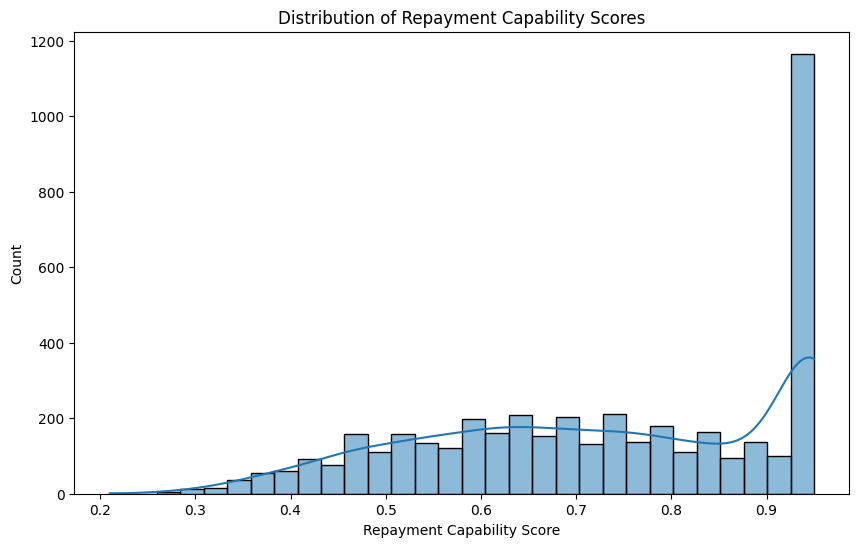

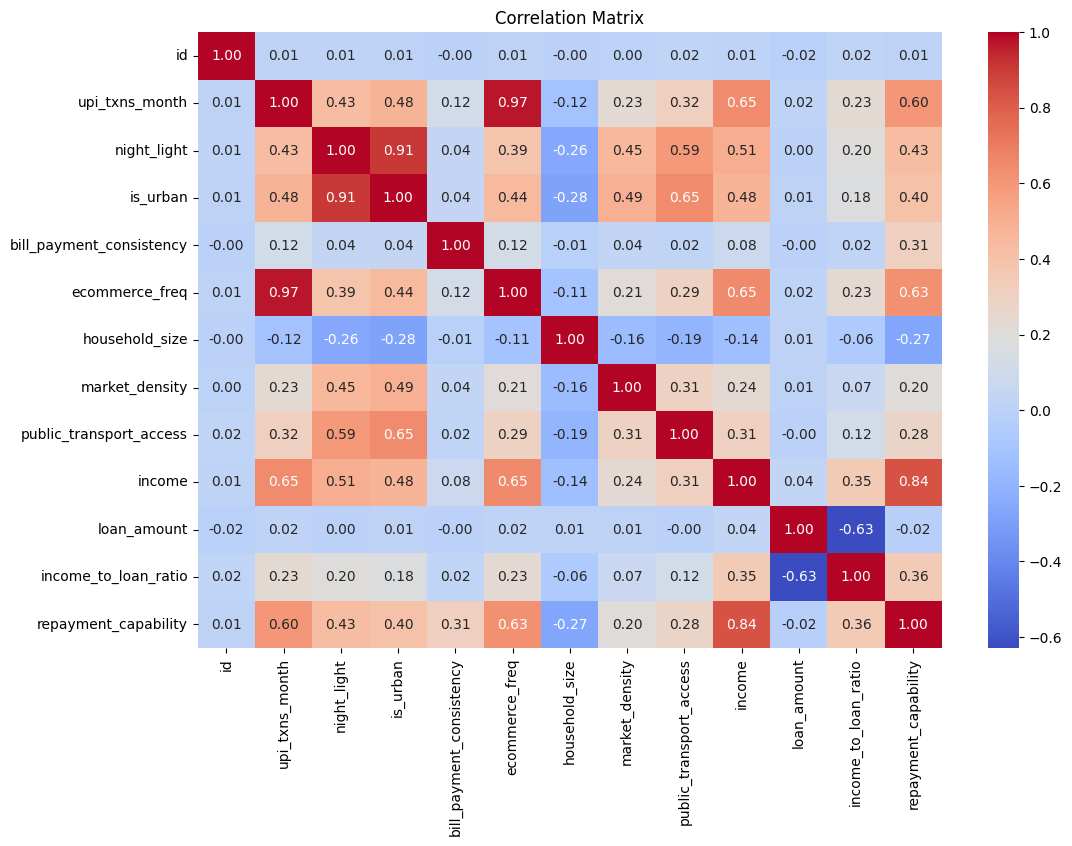

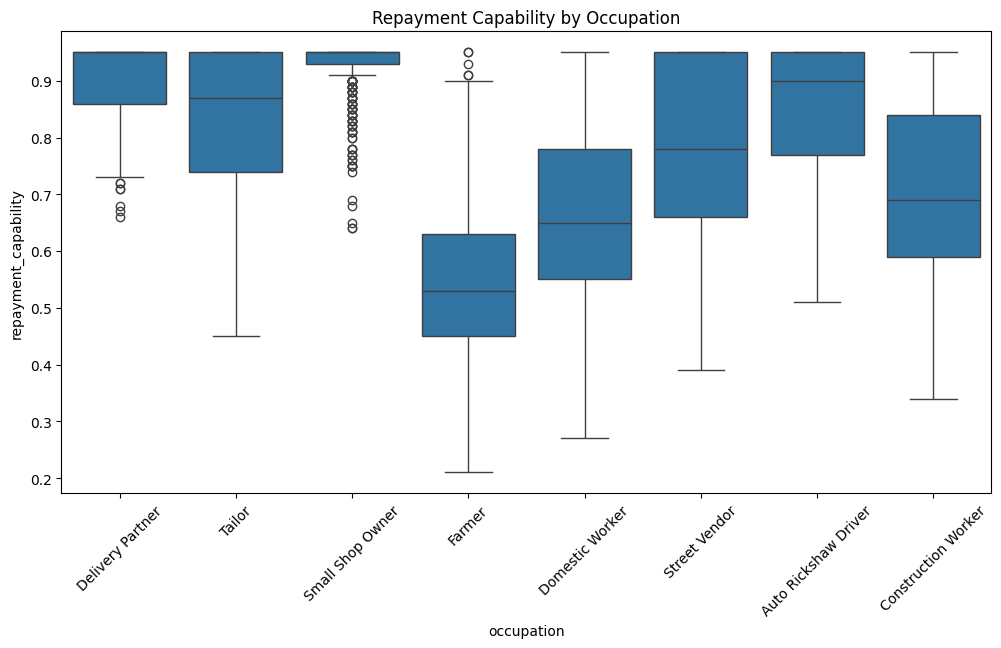

In [7]:
# ## 4. Exploratory Data Analysis (EDA)

# %%
# Basic statistics
print("Target variable (repayment_capability) statistics:")
print(data['repayment_capability'].describe())

# %%
# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['repayment_capability'], kde=True, bins=30)
plt.title('Distribution of Repayment Capability Scores')
plt.xlabel('Repayment Capability Score')
plt.ylabel('Count')
plt.show()

# %%
# Correlation matrix
plt.figure(figsize=(12, 8))
corr_matrix = data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# %%
# Repayment capability by occupation
plt.figure(figsize=(12, 6))
sns.boxplot(x='occupation', y='repayment_capability', data=data)
plt.xticks(rotation=45)
plt.title('Repayment Capability by Occupation')
plt.show()


In [8]:
# ## 5. Feature Engineering and Selection

# %%
# Create new features
data['debt_burden'] = data['loan_amount'] / data['income']
data['txn_frequency'] = data['upi_txns_month'] + data['ecommerce_freq']
data['housing_quality'] = data['housing_type'].map({'Kutcha': 0, 'Semi-Pucca': 1, 'Pucca': 2})

# %%
# Prepare features and target
X = data.drop(['id', 'repayment_capability'], axis=1)
y = data['repayment_capability']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [9]:
# ## 6. Model Selection & 7. Model Training

# Define preprocessing
# Correct the feature lists: mobile_recharge_freq should be categorical
numeric_features = ['upi_txns_month', 'night_light',
                   'bill_payment_consistency', 'ecommerce_freq', 'household_size',
                   'market_density', 'public_transport_access', 'income',
                   'loan_amount', 'income_to_loan_ratio', 'debt_burden', 'txn_frequency', 'housing_quality']
categorical_features = ['occupation', 'education', 'is_urban', 'skill_level', 'mobile_recharge_freq'] # Moved mobile_recharge_freq here

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# %%
# XGBoost Model
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

xgb_model.fit(X_train, y_train)

# Evaluate
y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost Initial Test RMSE: {rmse:.4f}")
print(f"XGBoost Initial R²: {r2:.4f}")

# %%
# Random Forest Model (baseline)
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
rmse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test RMSE: {rmse_rf:.4f}")
print(f"Random Forest R²: {r2_rf:.4f}")

XGBoost Initial Test RMSE: 0.0022
XGBoost Initial R²: 0.9363
Random Forest Test RMSE: 0.0021
Random Forest R²: 0.9396


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Best XGBoost Test RMSE: 0.0019
Best XGBoost R²: 0.9461


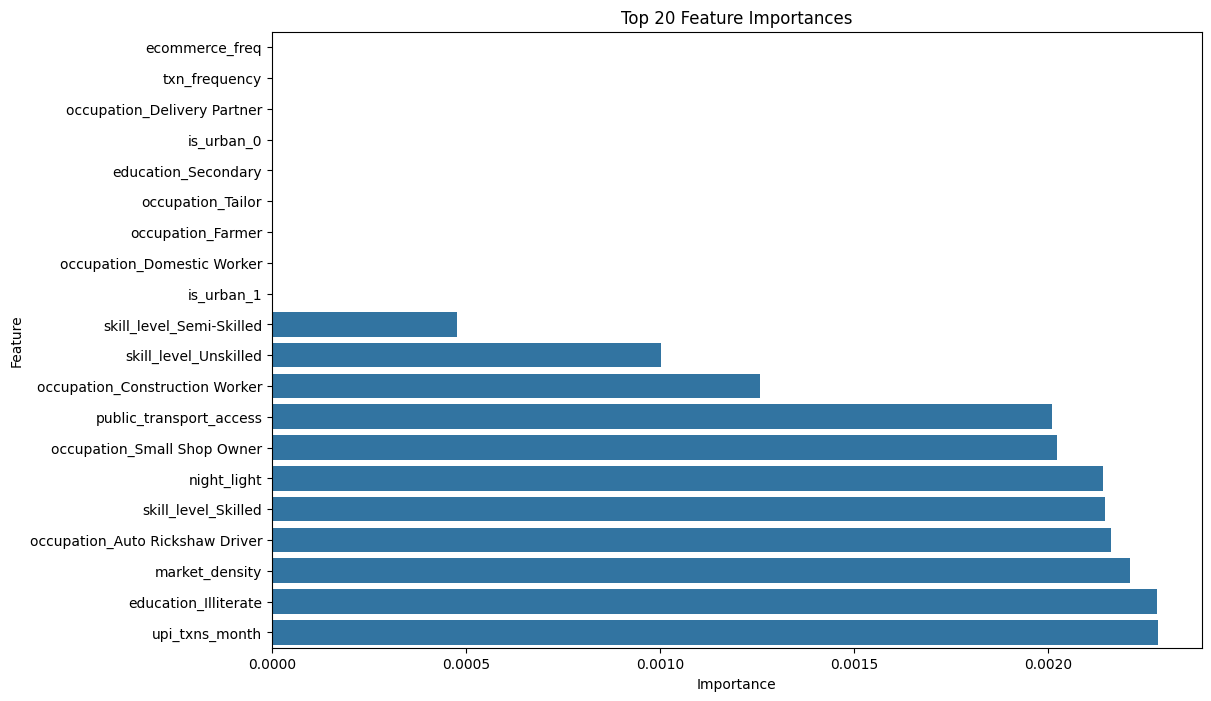

In [10]:
# ## 8. Model Evaluation and Tuning

# Hyperparameter tuning for XGBoost
param_grid = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=5,
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
rmse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best XGBoost Test RMSE: {rmse_best:.4f}")
print(f"Best XGBoost R²: {r2_best:.4f}")

# %%
# Feature importance
feature_importances = best_model.named_steps['regressor'].feature_importances_
cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(categorical_features)
all_features = numeric_features + list(cat_features)

importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
}).sort_values('Importance')

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances')
plt.show()


In [11]:
# ## 9. Model Deployment Preparation

# %%
# Save the best model
with open('loan_repayment_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# %%
# Example prediction function
def predict_repayment_capability(input_data):
    """
    Predict repayment capability for new applicant

    Args:
        input_data (dict): Dictionary containing all required features

    Returns:
        float: Predicted repayment capability score (0-1)
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_data])

    # Load model
    with open('loan_repayment_model.pkl', 'rb') as f:
        model = pickle.load(f)

    # Make prediction
    prediction = model.predict(input_df)

    return prediction[0]

# Example usage
example_applicant = {
    'occupation': 'Construction Worker',
    'education': 'Primary',
    'upi_txns_month': 25,
    'mobile_recharge_freq': 'Weekly',
    'night_light': 50,
    'is_urban': 1,
    'bill_payment_consistency': 1,
    'ecommerce_freq': 5,
    'skill_level': 'Semi-Skilled',
    'household_size': 4,
    'market_density': 0.3,
    'public_transport_access': 1,
    'housing_type': 'Semi-Pucca',
    'income': 20000,
    'loan_amount': 50000,
    'income_to_loan_ratio': 0.4
}

# Add engineered features
example_applicant['debt_burden'] = example_applicant['loan_amount'] / example_applicant['income']
example_applicant['txn_frequency'] = example_applicant['upi_txns_month'] + example_applicant['ecommerce_freq']
example_applicant['housing_quality'] = 1  # Semi-Pucca

prediction = predict_repayment_capability(example_applicant)
print(f"Predicted repayment capability: {prediction:.3f}")

Predicted repayment capability: 0.941


In [12]:
# ## 10. Model Monitoring Plan (Conceptual)

# %%
# Monitoring plan (conceptual - would be implemented in production)
monitoring_plan = """
Model Monitoring Plan:

1. Data Quality Monitoring:
   - Check for missing values in new data
   - Validate feature distributions monthly
   - Alert on significant statistical drift

2. Performance Monitoring:
   - Track RMSE on new labeled data
   - Compare with training performance
   - Alert if degradation >10%

3. Concept Drift Detection:
   - Monitor average predictions over time
   - Statistical tests for distribution changes
   - Quarterly model revalidation

4. Action Plan:
   - Retrain model monthly with new data
   - Emergency retrain if severe drift detected
   - Version control for all model updates
"""

print(monitoring_plan)


Model Monitoring Plan:

1. Data Quality Monitoring:
   - Check for missing values in new data
   - Validate feature distributions monthly
   - Alert on significant statistical drift

2. Performance Monitoring:
   - Track RMSE on new labeled data
   - Compare with training performance
   - Alert if degradation >10%

3. Concept Drift Detection:
   - Monitor average predictions over time
   - Statistical tests for distribution changes
   - Quarterly model revalidation

4. Action Plan:
   - Retrain model monthly with new data
   - Emergency retrain if severe drift detected
   - Version control for all model updates

